# Neural Network Final Model - Monte Cimone, Italy

In [1]:
import pandas as pd
import numpy as np
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import sys
sys.path.append('../../')
import config as cfg
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'CMN', 'This script is only for Monte Cimone, Italy. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Monte Cimone, Italy.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
1891,2009-10-24 09:00:00,1.0,-0.880436,0.060588,1.738949,-1.946638,4.098099,7.063369,6.355130,0.518473,...,-22.965242,-36.499023,-20.019196,-17.912952,0.807703,5.392985,-3.395360,-5.427581,-24.574867,-12.867394
2951,2012-05-27 11:00:00,0.0,-0.355637,-2.180124,-1.811570,-2.358627,2.310845,0.235204,-3.604782,2.069794,...,-17.938599,-3.686737,5.522683,24.941422,-4.957534,-8.540872,-8.930699,-7.392309,-17.201889,-21.524140
2528,2011-07-17 01:00:00,1.0,0.890413,0.697176,-1.703552,1.065871,1.861279,-1.444810,-4.129077,-1.139280,...,1.303554,6.730114,1.822527,10.064308,11.756118,-0.885604,-3.465022,-3.008861,-6.447056,4.603768
3768,2014-12-19 19:00:00,1.0,1.009785,7.226201,5.951276,-0.996228,1.524575,6.228138,3.671491,1.229791,...,3.455765,3.297551,10.736714,5.624229,4.066906,-0.868753,14.969716,1.926362,-2.035193,-6.027772
7279,2020-10-26 01:00:00,1.0,0.418747,-1.777036,-3.792504,-1.015638,0.709579,6.471547,5.641512,-3.134641,...,4.514553,-3.020018,-7.792196,-8.927485,12.716691,1.745074,5.965908,-4.403340,-13.488481,-0.249121


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 01:00:00. Length: 539
Val range: 2019-01-01 01:00:00 -> 2019-12-31 23:00:00. Length: 734
Test range: 2020-01-04 17:00:00 -> 2023-12-28 19:00:00. Length: 2726


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.5, 
                         learning_rate='constant', 
                         batch_size=250, 
                         early_stopping=False,
                         learning_rate_init=0.01,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
misclassification_rate_val = 1 - accuracy_score(y_val, y_pred_val)
misclassification_rate_train = 1 - accuracy_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")
print(f"Misclassification Rate on Training Set = {misclassification_rate_train:.3f}")
print(f"Misclassification Rate on Validation Set = {misclassification_rate_val:.3f}")

Precision on Training Set = 0.852
Precision on Validation Set = 0.909
Recall on Training Set = 0.954
Recall on Validation Set = 0.947
F1 Score on Training Set = 0.900
F1 Score on Validation Set = 0.928
Misclassification Rate on Training Set = 0.173
Misclassification Rate on Validation Set = 0.132


In [6]:
# evaluating model on test set
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
misclassification_rate_test = 1 - accuracy_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")
print(f"Misclassification Rate on Testing Set = {misclassification_rate_test:.3f}")

Precision on Testing Set = 0.897
Recall on Testing Set = 0.962
F1 Score on Testing Set = 0.928
Misclassification Rate on Testing Set = 0.131


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')
dump(nn_model, f'../model_files/nn_model_{site}.joblib')

['../model_files/nn_model_CMN.joblib']

### Confusion Matrix

Text(0.5, 1.0, 'Monte Cimone, Italy')

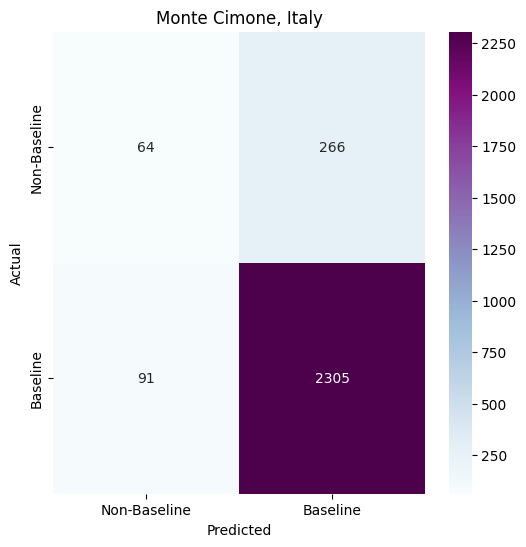

In [8]:
# creating a confusion matrix
conf_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])

conf_matrix.columns = ['Non-Baseline', 'Baseline']
conf_matrix.index = ['Non-Baseline', 'Baseline']

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.set_title(f'{site_name}')

### Assessing Feature Importance

In [9]:
# grouping features by category i.e. x-wind, y-wind, temporal etc.
u_features = [col for col in data.columns if 'u' in col]
v_features = [col for col in data.columns if 'v' in col]
temporal_features = ['day_of_year', 'time_of_day']
sp = ['sp']
blh = ['blh']

groups = [u_features, v_features, temporal_features, sp, blh]

In [10]:
original_score = accuracy_score(y_train, nn_model.predict(X_train))
importances = {}

for group in groups:
    scores_diff = []
    for _ in range(100):
        X_train_permuted = f.permute_group(X_train, group)
        
        permuted_score = accuracy_score(y_train, nn_model.predict(X_train_permuted))
        scores_diff.append(original_score - permuted_score)
    
    importances[str(group)] = np.mean(scores_diff)

# Sort groups by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)

In [11]:
# matching the group names to the sorted importances
n = len(groups)
group_names_sorted = []

for i in range(n):
    name = sorted_importances[i][0]

    if 'u10_0' in name:
        group_names_sorted.append('u-wind')

    elif 'v10_0' in name:
        group_names_sorted.append('v-wind')

    elif 'day_of_year' in name:
        group_names_sorted.append('temporal')

    elif 'sp' in name:
        group_names_sorted.append('sp')

    elif 'blh' in name:
        group_names_sorted.append('blh')

Text(0, 0.5, 'Feature Group')

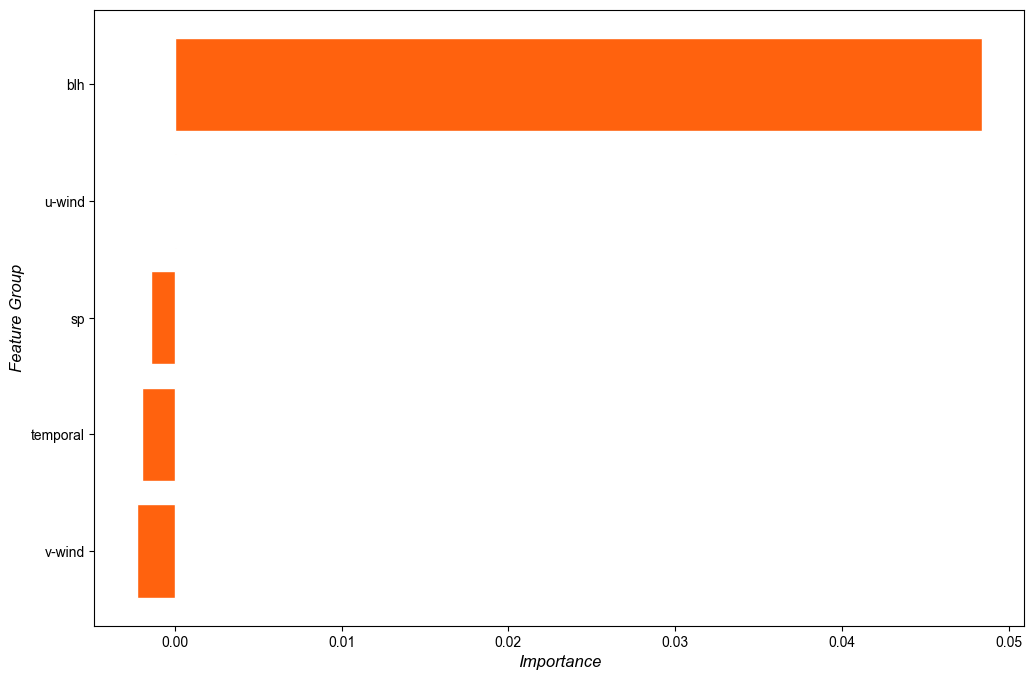

In [12]:
# Plotting the importances of the groups
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

ax.barh(group_names_sorted, [importance for _, importance in sorted_importances], color='#FF620E')

ax.set_xlabel('Importance', fontsize=12, fontstyle='italic')
ax.set_ylabel('Feature Group', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importances', fontsize=14)